In [1]:
from tdc.multi_pred import DTI
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle

In [2]:
from tdc.multi_pred import DrugRes
data = DrugRes(name = 'GDSC1')
split = data.get_split()

Downloading...
100%|██████████| 140M/140M [00:07<00:00, 19.4MiB/s] 
Loading...
Done!


In [8]:
data.get_gene_symbols()

Found local copy...
Loading...


array(['TSPAN6', 'TNMD', 'DPM1', ..., 'UBL5P2', 'TBC1D3P5', nan],
      dtype=object)

In [7]:
split["train"].loc[0,'Cell Line'].shape

(17737,)

In [9]:
config = {
    "dataset":{
        "dataset_bank":{
            'BindingDB_Ki':DTI(name = 'BindingDB_Ki'), 
            'DAVIS':DTI(name = 'DAVIS'),
            'KIBA':DTI(name = 'KIBA'),
        },
    },
}

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


### Dataset slits

In [10]:
for n in tqdm(config["dataset"]["dataset_bank"].keys()):
    config["dataset"]["dataset_bank"][n] = config["dataset"]["dataset_bank"][n].get_split()
    config["dataset"]["dataset_bank"][n]["train"]["ds_name"] = n
    config["dataset"]["dataset_bank"][n]["valid"]["ds_name"] = n
    config["dataset"]["dataset_bank"][n]["test"]["ds_name"] = n
    print("{} : columns - {}, shape - {}".format(
        n,
        config["dataset"]["dataset_bank"][n]["train"].columns, 
        config["dataset"]["dataset_bank"][n]["train"].shape)
          )
    

100%|██████████| 3/3 [00:00<00:00, 30.01it/s]

BindingDB_Ki : columns - Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y', 'ds_name'], dtype='object'), shape - (262374, 6)
DAVIS : columns - Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y', 'ds_name'], dtype='object'), shape - (18041, 6)
KIBA : columns - Index(['Drug_ID', 'Drug', 'Target_ID', 'Target', 'Y', 'ds_name'], dtype='object'), shape - (82360, 6)


In [65]:
train_dataset = pd.concat([d["train"] for d in tqdm(config["dataset"]["dataset_bank"].values())])
valid_dataset = pd.concat([d["valid"] for d in tqdm(config["dataset"]["dataset_bank"].values())])
test_dataset = pd.concat([d["test"] for d in tqdm(config["dataset"]["dataset_bank"].values())])

100%|██████████| 2/2 [00:00<00:00, 74235.47it/s]


In [66]:
train_dataset = train_dataset.groupby(["Drug1", "Drug2", "ds_name"]).agg({
    'Drug1_ID': list,
    'Y': list,
    'Drug2_ID': list
}).reset_index()

valid_dataset = valid_dataset.groupby(["Drug1", "Drug2", "ds_name"]).agg({
    'Drug1_ID': list,
    'Y': list,
    'Drug2_ID': list
}).reset_index()

test_dataset = test_dataset.groupby(["Drug1", "Drug2", "ds_name"]).agg({
    'Drug1_ID': list,
    'Y': list,
    'Drug2_ID': list
}).reset_index()

In [67]:
train_dataset.head()

,Drug1,Drug2,ds_name,Drug1_ID,Y,Drug2_ID
0,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C(C1C(C(C(C(O1)OC2(C(C(C(O2)OS(=O)(=O)O)OS(=O)...,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[85, 37, 153, 600, 315, 692, 433, 243, 74, 238...","[CID006398525, CID006398525, CID006398525, CID..."
1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C(N)(N)(Cl)Cl,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[85, 321, 444, 600, 756, 692, 315, 1221, 1, 15...","[CID005311048, CID005311048, CID005311048, CID..."
2,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C1=CC(=CC=C1C2C(C(=O)N2C3=CC=C(C=C3)F)CCC(C4=C...,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[216, 243, 153, 756, 315, 238, 600, 963, 464]","[CID000150311, CID000150311, CID000150311, CID..."
3,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C1C2CNCC1C3=CC4=NC=CN=C4C=C23,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[648, 85, 74, 50, 258]","[CID000170361, CID000170361, CID000170361, CID..."
4,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[85, 321, 315, 37, 756, 50, 367]","[CID000216326, CID000216326, CID000216326, CID..."


In [68]:
train_dataset.shape, train_dataset["ds_name"].value_counts()

((184736, 6),
 ds_name
 DrugBank    123570
 TWOSIDES     61166
 Name: count, dtype: int64)

<Axes: xlabel='Y'>

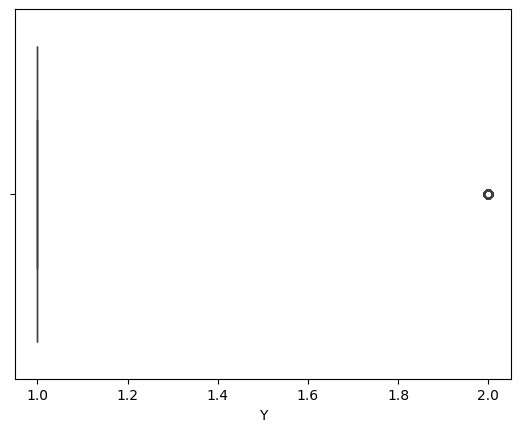

In [69]:
#draw a violin plot of the distributions of the len of the lists in "Y" column of train_dataset where ds_name = "DrugBank"
sns.boxplot(x=train_dataset.loc[train_dataset["ds_name"]=="DrugBank"]["Y"].apply(lambda x: len(x)))

<Axes: xlabel='Y'>

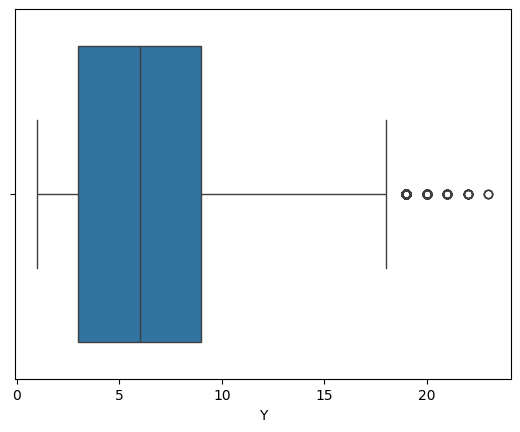

In [70]:
#draw a violin plot of the distributions of the len of the lists in "Y" column of train_dataset where ds_name = "DrugBank"
sns.boxplot(x=train_dataset.loc[train_dataset["ds_name"]=="TWOSIDES"]["Y"].apply(lambda x: len(x)))

In [71]:
### Individual Data Analysis

In [72]:
processed_dir = "processed_data"
os.makedirs(processed_dir, exist_ok=True)
train_dataset.to_csv(f"{processed_dir}/train.csv", index=False)
valid_dataset.to_csv(f"{processed_dir}/valid.csv", index=False)
test_dataset.to_csv(f"{processed_dir}/test.csv", index=False)

with open(f"{processed_dir}/config.pkl", "wb") as f:
    pickle.dump(config["metadata"], f)
